In [1]:
import matplotlib
import phonopy
import numpy as np
import API_phonopy as api_ph
import BTE_GreensFunction as BTEGF
import matplotlib.pyplot as plt
from matplotlib import cm, ticker 
from phonopy.units import VaspToTHz, EV, Angstrom, Kb, THz, THzToEv, Hbar

In [2]:
# Basic setups. 
Lmin = 0.1
Lmax = 100
Grating_um = np.logspace(np.log10(Lmin),np.log10(Lmax),201)
L_Angstrom = Grating_um*1e4
T0 = 100 # Temperature
mesh = [24,24,10]#
Nrepeat_fc2 = [5,5,3] 

x_direct = [0] # this is a tuple/list object

# Set a specific grating here for simulating \theta (t)
L0_um = 10
tmax = 6 
Nt = 101

# this doe sn't really matter. for calculations, as all velocities are input from BTE
poscar = 'POSCAR' 
sposcar_fc3 = '3RD.SPOSCAR'


is_isotope = True # include isotope
four_phonon = False # you will need to calculate 4ph scatterings 
write_data = True


# ------------------------------------- ShengBTE calculated phonon props -------------------------------------#
BTE_Folder = './Qmesh-242410/'
Dir_BTE_HarPhons = BTE_Folder+'BTE/' #remember to end with /
Dir_BTE_lifetime = BTE_Folder + 'T' + str(T0) +'K/'
Dir_BTE_MFD = BTE_Folder + 'T' + str(T0) +'K/' # set the same as RTA, then MFD is mean free path.
# ------------------------------------ Params to calculate Callaway GF ---------------------------------------#

D_boundary = 500e-6


In [3]:
# ----------------------------- Creating Phonon objects carrying BZ and qmesh ----------------------------------#
phonon = phonopy.load(unitcell_filename='POSCAR',
                      supercell_matrix=Nrepeat_fc2,
                      force_constants_filename='FORCE_CONSTANTS') # load with POSCAR and FORCE_SETS

fc2 = phonon.force_constants
phonon.run_mesh(mesh,is_gamma_center=True) 
# make gamma centered to be consistent with phono3py & ShengBTE

qpoints = phonon.get_mesh_dict()['qpoints']
w_qgrid = phonon.get_mesh_dict()['weights']
(Nqired,Ns) = phonon.get_mesh_dict()['frequencies'].shape #irreducible.
Wmat_grid = np.reshape(np.repeat(w_qgrid,Ns).T,(Nqired,Ns))
rots_qpoints = BTEGF.get_qpoint_rotsym(phonon) # rotations at q points.


qpoints_full,Vec_freqs,Vec_cqs,Vec_vqs,Vec_Fsc_qs,Vec_tau_qs,Vec_tauN_qs,Vec_tauR_qs,kappa_cvF,Nratio_qs = BTEGF.load_ShengBTE_Phonons(T0,phonon,Dir_BTE_HarPhons,Dir_BTE_MFD,Dir_BTE_lifetime,D_boundary,is_isotope,four_phonon)

Cap = np.sum(Vec_cqs)*EV/Angstrom**3

print('Thermal conductivity cvF (W/mK):')
print('when RTA is used in ShengBTE, cvF = cv^2tau')    
print(kappa_cvF) # phono3py, this is equivalent to RTA. 
print('Vol. heat capaicty (J/m3K):')
print(Cap)

kappa_r = (kappa_cvF[0,0]+kappa_cvF[1,1])/2
kappa_z = kappa_cvF[2,2]

/home/xinqian/Softwares/anaconda3/lib/python3.9/site-packages/phonopy/phonon/thermal_properties.py:43: RuntimeWarning: invalid value encountered in true_divide
  return Kb * x ** 2 * expVal / (expVal - 1.0) ** 2
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:564: RuntimeWarning: divide by zero encountered in true_divide
  tau_ph = 1./(scatt_rate_N+scatt_rate_U)
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:565: RuntimeWarning: divide by zero encountered in true_divide
  tau_N = 1./scatt_rate_N # ps.
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:568: RuntimeWarning: divide by zero encountered in true_divide
  tau_qs = 1./(scatt_rate_N+scatt_rate_U+scatt_rate_I+scatt_rate_b)
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:462: RuntimeWarning: invalid value encountered in double_scalars
  Vec_tau_sc[iqs] += Num/Den/weights[iq] # rescaled relaxatio time.


Thermal conductivity cvF (W/mK):
when RTA is used in ShengBTE, cvF = cv^2tau
[[ 1.78626898e+03 -1.35525272e-20  0.00000000e+00]
 [ 1.73641754e-20  1.78626898e+03  0.00000000e+00]
 [ 0.00000000e+00 -1.69406589e-21  9.25400855e+01]]
Vol. heat capaicty (J/m3K):
299842.5093726889


/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:654: RuntimeWarning: divide by zero encountered in true_divide
  Gamma = 1/Vec_tausc_qs


In [4]:
alpha,v0,eta,gamma = BTEGF.get_momentum_transCoeffs(kappa_cvF,Vec_cqs,Vec_vqs,Vec_freqs,Vec_tau_qs,Vec_tauR_qs, Nratio_qs,phonon,rots_qpoints)

# alpha and eta in Angstrom**2*THz,
# v0 in Angstrom*THz
# gamma in THz.

k = 2*np.pi/np.flip(L_Angstrom)# Grating wavevector of TTG
k_um = 1/np.flip(Grating_um)
omega_plus,omega_minus,vss = BTEGF.get_secsound_dispersion(k,alpha,eta,v0,gamma,lowOrder=True)

/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:100: RuntimeWarning: invalid value encountered in double_scalars
  v0 = np.sqrt(Pi**2/A/C)
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:101: RuntimeWarning: invalid value encountered in double_scalars
  gamma = Gamma/A
/home/xinqian/Softwares/API_Phonons/BTE_GreensFunction.py:102: RuntimeWarning: invalid value encountered in double_scalars
  eta = M/A


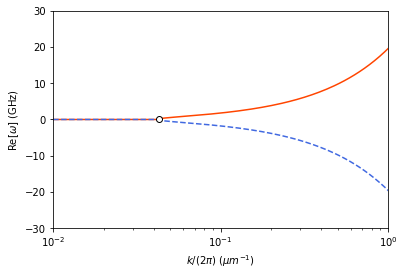

In [5]:

plt.semilogx(k_um,omega_plus.real*1000,color='orangered')
plt.semilogx(k_um,omega_minus.real*1000,'--',color='royalblue')

# THis is only valid for low-order.

APT_broken = omega_plus.real>0
k_ss_region = k_um[APT_broken]
kEP = k_ss_region[0]
Im_w_ss_region = omega_plus.imag[APT_broken]
Im_omega_EP = Im_w_ss_region[0]

plt.plot(kEP,0,'o',color='white',mec='black')
plt.xlim([0.01,1])
plt.ylim([-30,30])
plt.xlabel('$k/(2\pi)$ ($\mu m^{-1}$)')
plt.ylabel('Re[$\omega$] (GHz)')

Disp = np.array([k_um,omega_plus.real*1000,omega_minus.real*1000,omega_plus.imag*1000,omega_minus.imag*1000])
api_ph.write_2D_array('Disp_omega_T'+str(T0)+'K.txt',Disp,'# k (um^-1)  Re_wp  Re_wm Im_wp   Im_wm')

Text(0, 0.5, '-Im[$\\omega$] (GHz)')

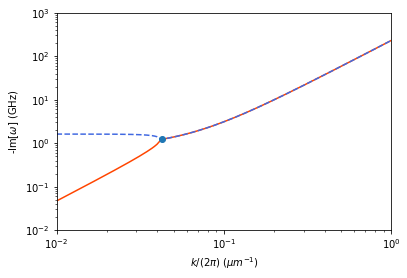

In [6]:
plt.loglog(k_um,-omega_plus.imag*1000,color='orangered')
plt.loglog(k_um,-omega_minus.imag*1000,'--',color='royalblue')
plt.semilogy(kEP,-Im_omega_EP*1000,'o')
plt.xlim([0.01,1])
plt.ylim([1e-2,1000])
plt.xlabel('$k/(2\pi)$ ($\mu m^{-1}$)')
plt.ylabel('-Im[$\omega$] (GHz)')

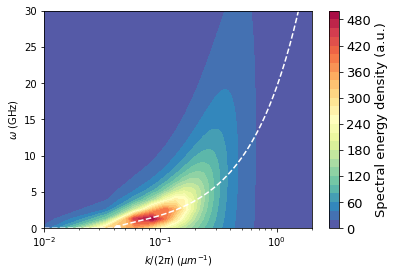

In [7]:
# Compute Spectral energy density
K,OMEGA,SpecFunc = BTEGF.calc_SED_secsound(k_um,omega_plus)
plt.contourf(K,OMEGA*1000,SpecFunc,cmap='Spectral_r',levels=25)
plt.plot(k_um,omega_plus.real*1000,'--',color='white')
plt.plot(kEP,0.0001,'o',color='white')

plt.xscale('log')
plt.xlim([0.01,2])
plt.ylim([0,30])
plt.clim([0,500])
plt.xlabel('$k/(2\pi)$ ($\mu m^{-1}$)')
plt.ylabel('$\omega$ (GHz)')
plt.rcParams.update({'font.size': 13})

cbar = plt.colorbar()
cbar.set_label('Spectral energy density (a.u.)')
plt.savefig("SpectralFunc" +str(T0)+ "K.svg",dpi=600,bbox_inches='tight')

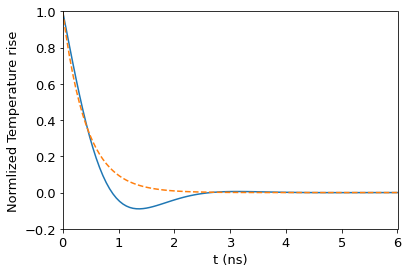

In [8]:
k0 = 2*np.pi/(L0_um*1e4)
omega_plus,omega_minus,vss = BTEGF.get_secsound_dispersion(k0,alpha,eta,v0,gamma,lowOrder=False)
wssp_GHz = omega_plus.real*1e3
gssp_GHz = omega_plus.imag*1e3

wssm_GHz = omega_minus.real*1e3
gssm_GHz = omega_minus.imag*1e3

t_ns = np.linspace(0,tmax,Nt)
T1 = np.exp(gssp_GHz*t_ns/2)*np.cos(wssp_GHz*t_ns) #+ np.exp(gssm_GHz*t_ns/2)*np.cos(wssm_GHz*t_ns)
TF = np.exp(-alpha*k0**2*1e3*t_ns)

plt.plot(t_ns,T1,t_ns,TF,'--')
plt.xlim([0,np.max(t_ns)])
plt.ylim([-0.2,1])
plt.xlabel('t (ns)')
plt.ylabel('Normlized Temperature rise')

Data = np.array([t_ns,T1,TF])
api_ph.write_2D_array('TTG_L'+str(L0_um)+'um_T'+str(T0)+'K.txt',Data)